<a href="https://colab.research.google.com/github/koba341/AutoML/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import needed packages
import pandas as pd
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import numpy as np
from time import time
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from heapq import nlargest
!pip install scikit-optimize
import torch
!pip install pymoo
#!pip install xlrd==1.2.0
import xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import autosklearn

In [ ]:
import warnings

In [ ]:
!pip install scipy==1.7.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.2
    Uninstalling scipy-1.7.2:
      Successfully uninstalled scipy-1.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Feature Selection

# Inhaltsverzeichnis
I. Bemerkungen \\
II. Import Datasets \\
III. Gaussprozess, RandomForest (kein RandomForest Algorithmus momentan)

1. Lasso \\
Lasso Übersicht, LassoCV, Lasso mit HPO, Lasso mit NSGAII
2. Ridge \\
Ridge Übersicht, RidgeCV, Ridge mit HPO, Ridge mit NSGAII
3. ElasticNet \\
ElasticNet Übersicht, ElasticNetCV, ElasticNet mit HPO, ElasticNet mit NSGAII

**Bemerkungen 17.06.**
1.   Wenn etwas programmiert wird, Hintergrundinformationen mitliefern: Wie funktioniert ein Gaussprozess zb... Zu RandomForest zB nichts schreiben, da sehr bekannt 
2.   ~Hperparametersuche mit AutoML und NSGA II~
3.   ~Diagramme wie https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py einbauen und erklären~
4.   Bei allen Verfahrne nochmal Algorithmus kurz zeigen und Entscheidungsprozess für die selected Features erklären + Diagramme
5.   Github auf Privat stellen, Farzad Access geben
6.   R2 definieren - welches R2 wird genutzt? Manche geben negative Werte, manche nicht - unbedingt definieren. :https://en.wikipedia.org/wiki/Coefficient_of_determination Von 1 bis - unendlich
7.   ~Bei Modellerstellung: Immer NSGA II (+ gewünschte Modelle) und AutoML zuerst nutzen - Hyperparameter Optimization~
8.   Ensembles auch erstellen. Ensembles mit gemischten Algorithmen bei den traditionellen Methoden. Alles nutzen. Nächster Schritt: Ensembles mit neuronalen Netzwerken aus NAS.
9.  ~Beide Concrete Datensätze nutzen (das mit 1000 und 100 Datenpunkten)~




**24.06.**
Auto-Sklearn wie bei random Forest ipnyb einfügen.



*   Auswahl Hyperparameter
*   Training mit Feature Selection
*   Entscheidungsprozess bei Lasso, Ridge und Elastic



A search consists of:

    an estimator (regressor or classifier such as sklearn.svm.SVC());

    a parameter space;

    a method for searching or sampling candidates;

    a cross-validation scheme; and

    a score function.

# Import Datasets
Es gibt zwei Datensätze. Alle Algorithmen wurden mit dem kleinen slump_test.csv Datenset durchgeführt.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AutoML/slump_test.csv")
X = data.iloc[:, 1:10].to_numpy()
y = data.iloc[:, 10].to_numpy()
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, train_size=0.90, random_state=1) # create training and test dataset. 
data_cols = data.columns.copy().tolist()
data_cols.remove('No')
data_cols.remove('Compressive Strength (28-day)(Mpa)')

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/AutoML/Concrete_Data.xls', engine='xlrd')
X = data.iloc[:, 0:8].to_numpy()
y = data.iloc[:, 8].to_numpy()
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, train_size=0.90, random_state=1)

data_cols = data.columns.copy().tolist()
data_cols.remove('Concrete compressive strength(MPa, megapascals)')

# Gaussprozess, Random Forest

Gaussprozessregression mit allen Features

**Vereinfachter Gaussprozess mit Default-Hyperparametern im Kernel** \\
Source: https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process \\
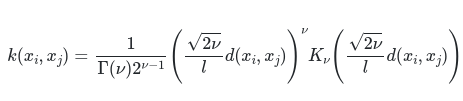

In [ ]:
def train_gp(X_train, y_train):
  from sklearn.gaussian_process import GaussianProcessRegressor
  from sklearn.gaussian_process.kernels import Matern


  kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
  gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=0).fit(X_train, y_train)
  return gpr

gpr = train_gp(X_train, y_train)
r2_test_gpr = gpr.score(X_test, y_test)
print('R2 for Test data: {}'.format(r2_test))

R2 for Test data: 0.9367519645780462


Random Forest

In [ ]:
def train_rf(X_train, y_train, features):
  from sklearn.ensemble import RandomForestRegressor


  rf = RandomForestRegressor(n_estimators=100, max_depth=features-1, random_state = 0).fit(X_train, y_train)
  return rf

features = len(data_cols)
rf = train_rf(X_train, y_train, features)
r2_test_rf = rf.score(X_test, y_test)
print('R2 for Test data: {}'.format(r2_test))

R2 for Test data: 0.9367519645780462


In [ ]:
# save the data
# algorithms = ['GridsearchCV', 'HPO mit BO', 'HPO mit NSGAII', 'HPO mit AutoML']
algorithms = ['No Feature Selection', 'GridsearchCV', 'HPO mit BO', 'HPO mit NSGAII']

LassoGPRR2 = [r2_test_gpr]
LassoRFR2 = [r2_test_rf]

RidgeGPRR2 = [r2_test_gpr]
ElasticNetGPRR2 = [r2_test_gpr]

RidgeRFR2 = [r2_test_rf]
ElasticNetRFR2 = [r2_test_rf]

# p-Value and ANOVA

Example from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html \\
Intuition: https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w \\

In [ ]:
f_stat, p_val = f_regression(X_train, y_train)
print(f_stat)
print()
print(p_val)

[23.81702706  9.54253105 23.03769415  8.52436021  0.16074755  2.33534826
  2.46413992  6.22919137  2.68867538]

[4.55546206e-06 2.67047841e-03 6.28108989e-06 4.42727135e-03
 6.89419463e-01 1.29973780e-01 1.19980724e-01 1.43880487e-02
 1.04554728e-01]


In [ ]:
k = 6
anova_filter = SelectKBest(f_regression, k=k)
X_new = anova_filter.fit_transform(X_train, y_train)

print('Shape of X: ', X_train.shape)
print('Shape of X after ANOVA: ', X_new.shape)
idx = np.argsort(anova_filter.scores_)[::-1][:k]+1 #+1 because of No. - Attribute
print('Selected Features: ', data.columns[idx])
idx = np.argsort(anova_filter.scores_)[::-1][:k]

Shape of X:  (92, 9)
Shape of X after ANOVA:  (92, 6)
Selected Features:  Index(['Cement', 'Fly ash', 'Slag', 'Water', 'SLUMP(cm)', 'FLOW(cm)'], dtype='object')


# Lasso


1.   Lasso Übersicht
2.   LassoCV (Gridsearch Equivalent)
3.   Lasso mit HPO (Hyperparameter Optimization mit Bayesian Optimization)
4.   Lasso mit NSGAII Hyperparameterauswahl 


**1. Lasso Übersicht**

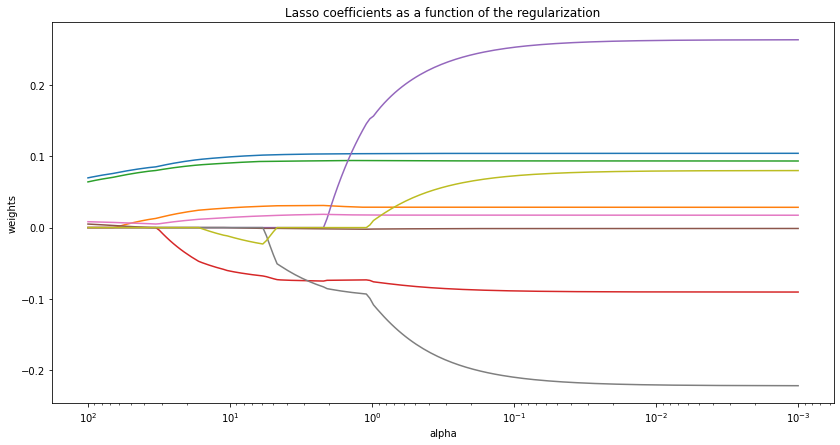

In [ ]:
from sklearn.linear_model import Lasso
warnings.filterwarnings("ignore")
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(14,7))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

# insert labels 

**2. LassoCV (Gridsearch Equivalent)**

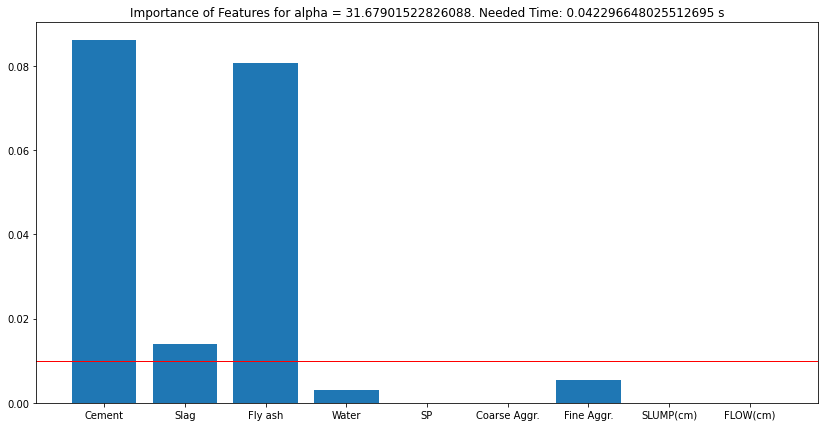

In [ ]:
from sklearn.linear_model import LassoCV
start_time = time()
model = LassoCV(cv=3, fit_intercept=False).fit(X_train, y_train)
needed_time = time() - start_time
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(model.alpha_, needed_time))
plt.bar(data_cols, importance)
plt.axhline(y=0.01,linewidth=1, color='r')


In [ ]:
impIdx = np.nonzero(importance)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
LassoGPRR2.append(r2_test)
print('We have {} Features.'.format(len(impIdx)))
print('GPR: R2 for Test data: {}'.format(r2_test))

rf = train_rf(X_train_sel, y_train, len(impIdx))
r2_test = rf.score(X_test_sel, y_test)
LassoRFR2.append(r2_test)
print('We have {} Features.'.format(len(impIdx)))
print('RF: R2 for Test data: {}'.format(r2_test))

We have 5 Features.
GPR: R2 for Test data: 0.9684110210072086
We have 5 Features.
RF: R2 for Test data: 0.8323823142848302


**3. Lasso mit HPO (Hyperparameter Optimization mit Bayesian Optimization)** \\
Source Code: https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html \\
How it works: https://ax.dev/docs/bayesopt \\

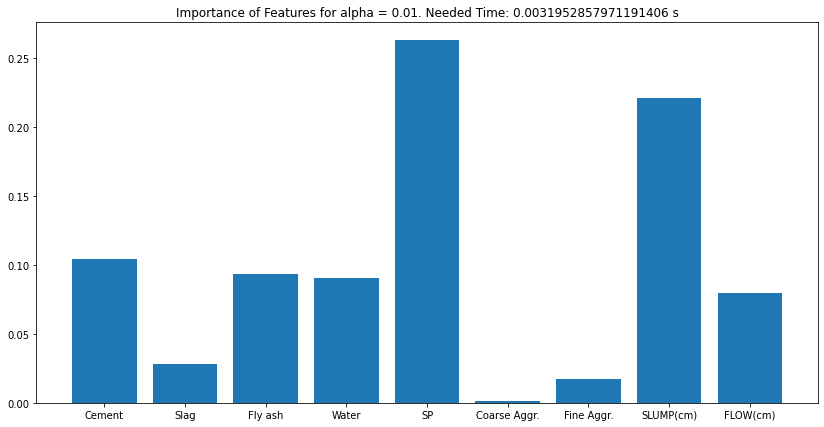

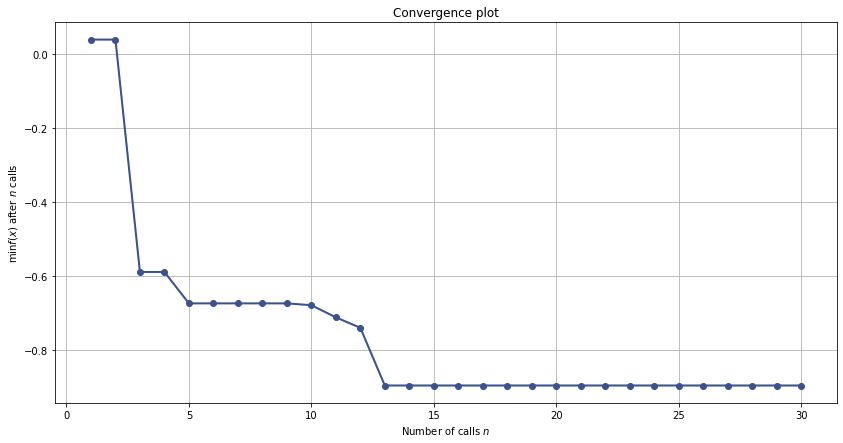

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from sklearn.linear_model import Lasso

start_time = time()
opt = BayesSearchCV(
    Lasso(),
    {
        'alpha': Real(10E-3, 10E+2),
        'fit_intercept': ['False']
    },
    scoring='r2',
    n_iter=30,
    cv=3
)
needed_time = time() - start_time
opt.fit(X_train, y_train)

alpha = opt.best_params_['alpha']

lasso = Lasso(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(lasso.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, needed_time))
plt.bar(data_cols, importance)
plt.figure(figsize=(14, 7))
plot_convergence(opt.optimizer_results_)

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
LassoGPRR2.append(r2_test)
print('We have {} Features.'.format(len(impIdx)))
print('GPR: R2 for Test data: {}'.format(r2_test))

rf = train_rf(X_train_sel, y_train, len(impIdx))
r2_test = rf.score(X_test_sel, y_test)
LassoRFR2.append(r2_test)
print('We have {} Features.'.format(len(impIdx)))
print('RF: R2 for Test data: {}'.format(r2_test))

We have 8 Features.
GPR: R2 for Test data: 0.9819852862817915
We have 8 Features.
RF: R2 for Test data: 0.9316990944582422


**4. Lasso mit NSGA II**

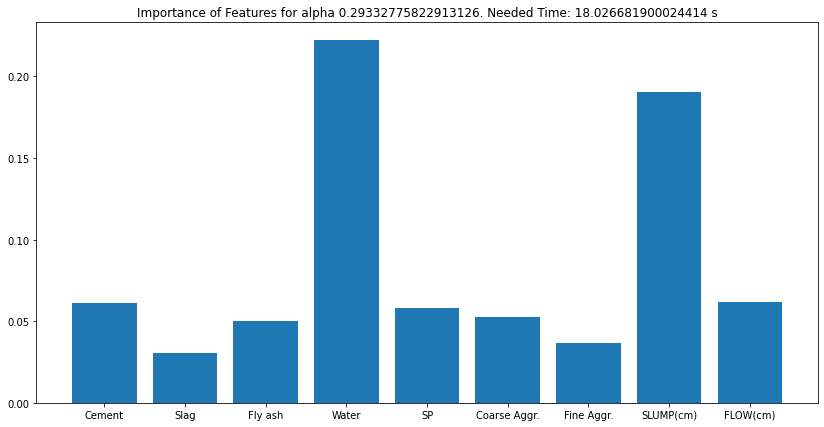

In [ ]:
from sklearn.model_selection import cross_val_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from sklearn.linear_model import Lasso
from time import time

class MyProblem(ElementwiseProblem):

    def __init__(self, estimator):
        super().__init__(n_var=1,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([10E-3]),
                         xu=np.array([10E+2]))
        self.estimator = estimator

    def _evaluate(self, x, out, *args, **kwargs):
        lasso = self.estimator(alpha=x[0], fit_intercept=False)
        r2 = cross_val_score(lasso, X_train, y_train, cv=3, scoring='r2')
        score = 1 - np.abs(r2.mean())

        out["F"] = [score]


problem = MyProblem(estimator=Lasso)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx"),
    mutation=get_mutation("real_pm"),
    eliminate_duplicates=True)

termination = get_termination("n_gen", 50)

start_time = time()

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)
needed_time = time() - start_time

X_ = res.X  # minimize returns result objects
F_ = res.F

for alpha in X_:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    importance = np.abs(lasso.coef_)
    plt.figure(figsize=(14, 7))
    plt.bar(data_cols, importance)
    plt.title('Importance of Features for alpha {}. Needed Time: {} s'.format(alpha, needed_time))
    plt.show()

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
LassoGPRR2.append(r2_test)
print('We have {} Features.'.format(len(impIdx)))
print('GPR: R2 for Test data: {}'.format(r2_test))

rf = train_rf(X_train_sel, y_train, len(impIdx))
r2_test = rf.score(X_test_sel, y_test)
LassoRFR2.append(r2_test)
print('We have {} Features.'.format(len(impIdx)))
print('RF: R2 for Test data: {}'.format(r2_test))

We have 9 Features.
GPR: R2 for Test data: 0.9753063612921088
We have 9 Features.
RF: R2 for Test data: 0.9367519645780462


**5. Lasso mit AutoML**

In [ ]:
#from autosklearn.regression import AutoSklearnRegressor
start_time = time()
reg = AutoSklearnRegressor(
    time_left_for_this_task=180,
    per_run_time_limit=30,
    include={
        'regressor': ['Lasso']
    },
    ensemble_size=1
)
reg.fit(X_train, y_train)
needed_time = time() - start_time
model_dict = reg.show_models()
key = list(model_dict.keys())[0]
alpha = model_dict[key]['sklearn_regressor'].alpha

lasso = Lasso(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(lasso.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, needed_time))
plt.bar(data_cols, importance)

[WARNING] [2022-06-24 15:06:59,813:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 197 not found
[WARNING] [2022-06-24 15:06:59,813:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 235 not found
[WARNING] [2022-06-24 15:06:59,814:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 270 not found
[WARNING] [2022-06-24 15:06:59,814:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 163 not found
[WARNING] [2022-06-24 15:06:59,814:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 67 not found
[WARNING] [2022-06-24 15:06:59,814:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 34 not found
[WARNING] [2022-06-24 15:06:59,814:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 86 not found
[WARNING] [2022-06-24 15:06:59,814:Client-AutoMLSMBO(1)::4ada0b1c-f3cf-11ec-8244-0242ac1c0002] Configuration 240 not found
[WARNING] [2022-06-

**Plot all Lasso Solutions**

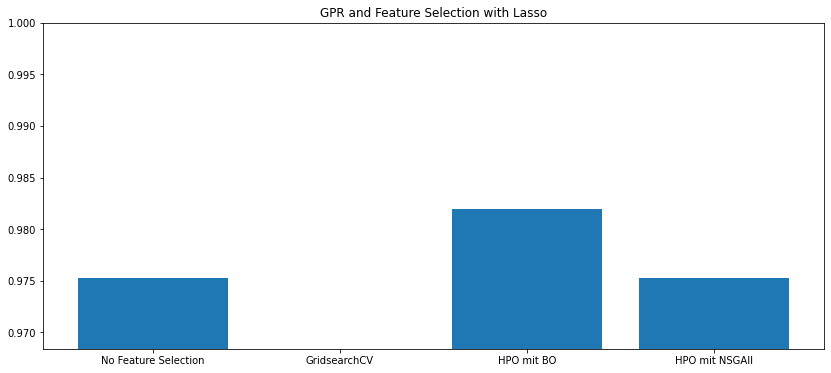

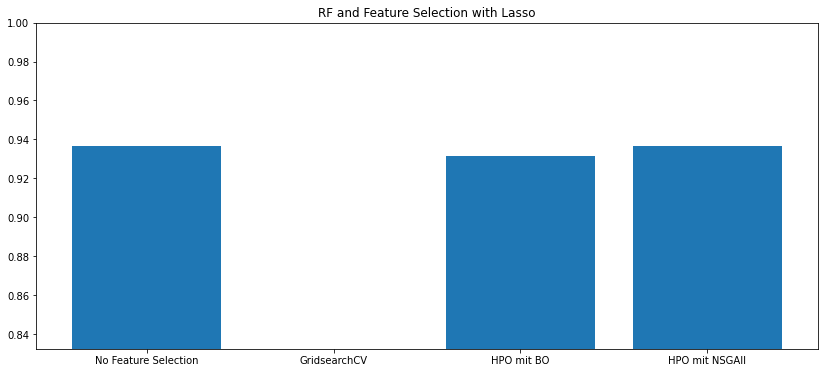

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(algorithms, LassoGPRR2)
plt.title('GPR and Feature Selection with Lasso')
plt.ylim([min(LassoGPRR2), 1])
plt.show()

plt.figure(figsize=(14,6))
plt.bar(algorithms, LassoRFR2)
plt.title('RF and Feature Selection with Lasso')
plt.ylim([min(LassoRFR2), 1])
plt.show()

# Ridge Regression

How to decide which Features to select? https://stats.stackexchange.com/questions/506397/how-to-select-the-best-feature-set-from-ridge-regression

Wie genau funktioniert Ridge Regression? Welche Faktoren sind wichtig? Hyperparameterauswahl mit AutoML und NSGAII - GridSearch ist veraltet.

1.   Ridge Übersicht
2.   RidgeCV (Gridsearch Equivalent)
3.   Ridge mit HPO (Hyperparameter Optimization mit Bayesian Optimization)
4.   Ridge mit NSGAII Hyperparameterauswahl 

**1. Ridge Übersicht**

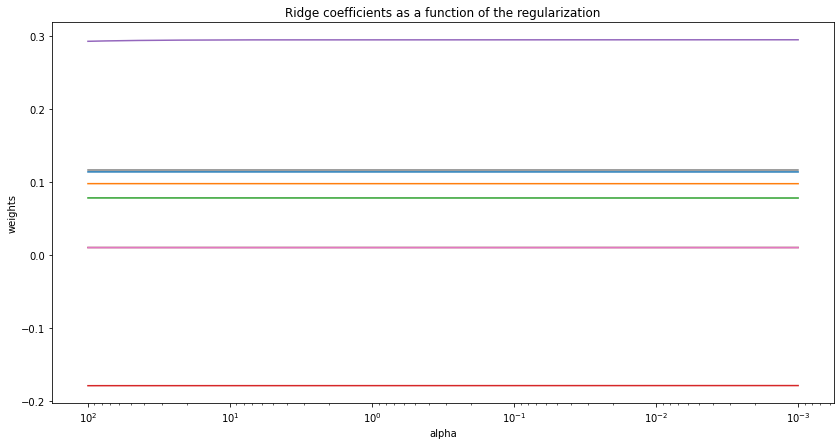

In [ ]:
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

plt.figure(figsize=(14,7))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

**2. RidgeCV (Gridsearch Equivalent)**

<BarContainer object of 8 artists>

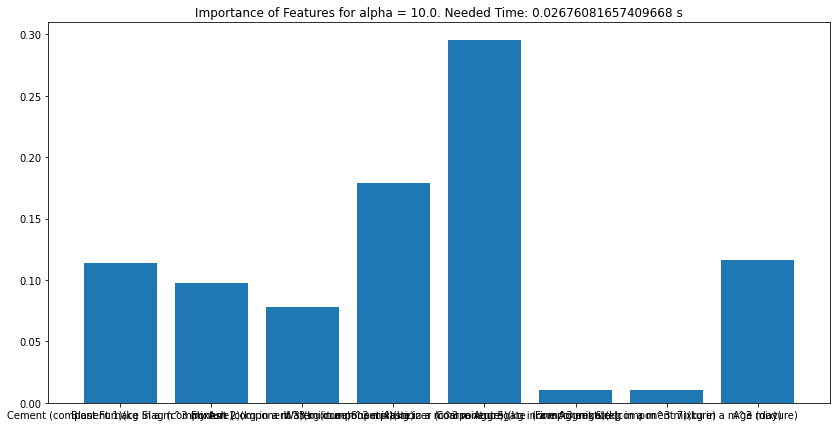

In [ ]:
from sklearn.linear_model import RidgeCV
start_time = time()
model = RidgeCV(cv=3, fit_intercept=False).fit(X_train, y_train)
needed_time = time() - start_time
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(model.alpha_, needed_time))
plt.bar(data_cols, importance)

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.010148926204125663


**3. Ridge mit HPO (Hyperparameter Optimization mit Bayesian Optimization)**

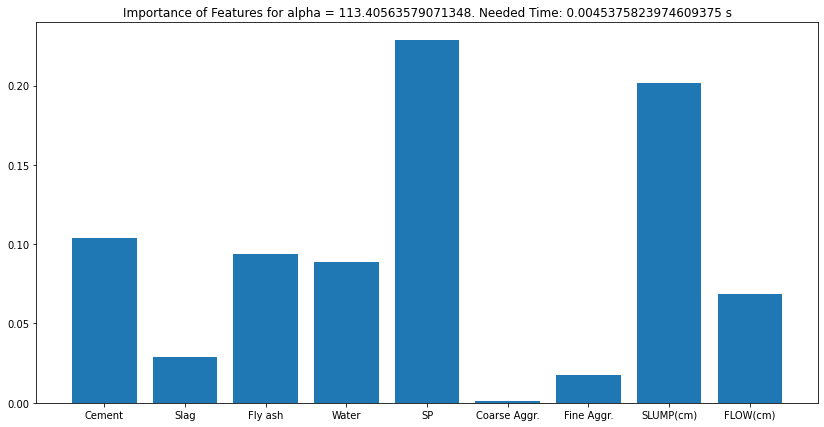

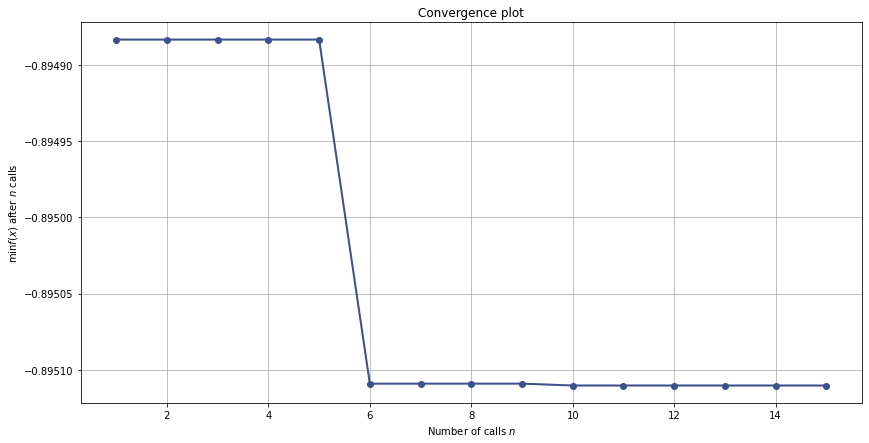

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from sklearn.linear_model import Ridge

start_time = time()
opt = BayesSearchCV(
    Ridge(),
    {
        'alpha': Real(10E-5, 10E+2),
        'fit_intercept': ['False']
    },
    scoring='r2',
    n_iter=15,
    cv=3,
)
end_time = time() - start_time

opt.fit(X_train, y_train)

alpha = opt.best_params_['alpha']

ridge = Ridge(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, end_time))
plt.bar(data_cols, importance)
plt.figure(figsize=(14, 7))
plot_convergence(opt.optimizer_results_)

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.9819852862817915


**4. Ridge mit NSGAII Hyperparameterauswahl**

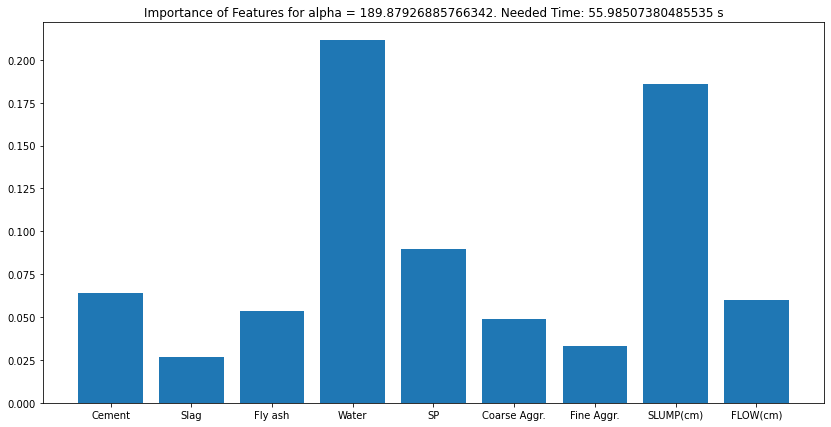

In [ ]:
from sklearn.model_selection import cross_val_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from sklearn.linear_model import Ridge
from time import time

class MyProblem(ElementwiseProblem):

    def __init__(self, estimator):
        super().__init__(n_var=1,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([10E-3]),
                         xu=np.array([10E+2]))
        self.estimator = estimator

    def _evaluate(self, x, out, *args, **kwargs):
        estimator = self.estimator(alpha=x[0], fit_intercept=False)
        r2 = cross_val_score(estimator, X_train, y_train, cv=3, scoring='r2')
        score = 1 - np.abs(r2.mean())

        out["F"] = [score]


problem = MyProblem(estimator=Ridge)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx"),
    mutation=get_mutation("real_pm"),
    eliminate_duplicates=True)

termination = get_termination("n_gen", 300)

start_time = time()

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)
end_time = time() - start_time
X_ = res.X  # minimize returns result objects
F_ = res.F

for alpha in X_:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    importance = np.abs(ridge.coef_)
    plt.figure(figsize=(14, 7))
    plt.bar(data_cols, importance)
    plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, end_time))
    plt.show()

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 9 Features.
R2 for Test data: 0.9753063612921089


# ElasticNet
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

1.   ElasticNet Übersicht
2.   ElasticNetCV (Gridsearch Equivalent)
3.   ElasticNet mit HPO (Hyperparameter Optimization mit Bayesian Optimization)
4.   ElasticNet mit NSGAII Hyperparameterauswahl 

**1. ElasticNet Übersicht**



In [ ]:
from sklearn.linear_model import ElasticNet
from ipywidgets import interact

warnings.filterwarnings("ignore")
n_alphas = 200
alphas = np.logspace(-3, 2, n_alphas)
@interact(l1_ratio=(0.1, 1))
def plot_coeff(l1_ratio=0.5):
  coefs = []
  for a in alphas:
      model = ElasticNet(alpha=a, l1_ratio=l1_ratio, fit_intercept=False)
      model.fit(X_train, y_train)
      coefs.append(model.coef_)

  plt.figure(figsize=(14,7))
  ax = plt.gca()
  ax.plot(alphas, coefs)
  ax.set_xscale("log")
  ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
  plt.xlabel("alpha")
  plt.ylabel("weights")
  plt.title("ElasticNet coefficients as a function of the regularization for l1_ratio = {}".format(l1_ratio))
  plt.axis("tight")
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='l1_ratio', max=1.0, min=0.1), Output()), _dom_classe…

****2. ElasticNetCV (Gridsearch Equivalent)****

<BarContainer object of 8 artists>

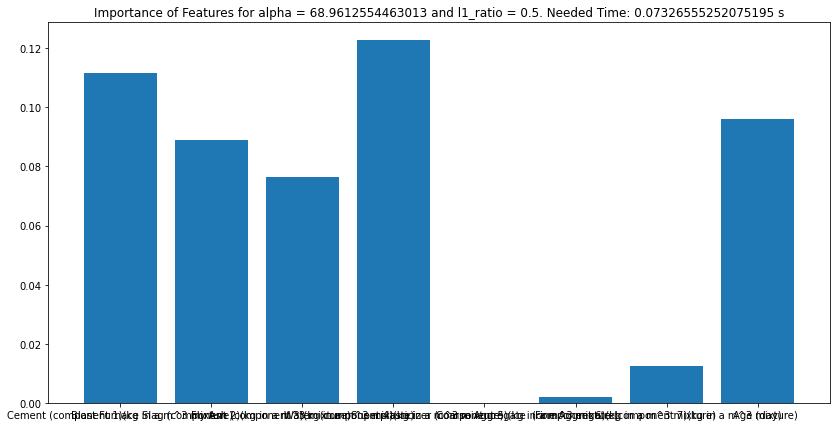

In [ ]:
from sklearn.linear_model import ElasticNetCV
start_time = time()
model = ElasticNetCV(cv=3, n_alphas=100, fit_intercept=False).fit(X_train, y_train)
needed_time = time() - start_time
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {} and l1_ratio = {}. Needed Time: {} s'.format(model.alpha_, model.l1_ratio_, needed_time))
plt.bar(data_cols, importance)

In [ ]:
impIdx = np.nonzero(importance)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 7 Features.
R2 for Test data: 0.8003400985771888




**3. ElasticNet mit HPO (Hyperparameter Optimization mit Bayesian Optimization)**


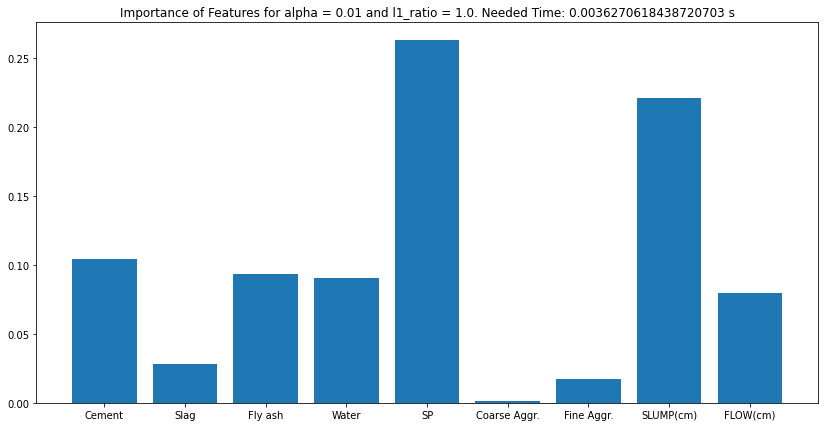

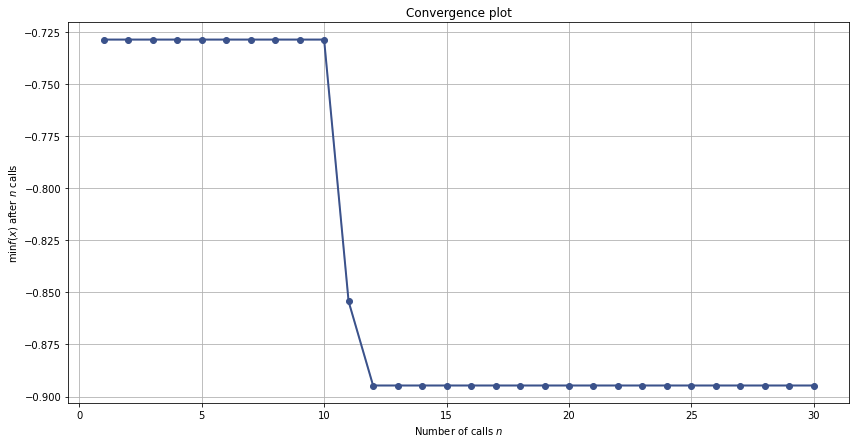

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from sklearn.linear_model import ElasticNet

start_time = time()
opt = BayesSearchCV(
    ElasticNet(),
    {
        'alpha': Real(10E-3, 10E+2),
        'l1_ratio': Real(0, 1),
        'fit_intercept': ['False']
    },
    scoring='r2',
    n_iter=30,
    cv=3,
)
end_time = time() - start_time

opt.fit(X_train, y_train)

alpha = opt.best_params_['alpha']
l1_ratio = opt.best_params_['l1_ratio']

elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(elastic.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {} and l1_ratio = {}. Needed Time: {} s'.format(alpha, l1_ratio, end_time))
plt.bar(data_cols, importance)
plt.figure(figsize=(14, 7))
plot_convergence(opt.optimizer_results_)

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 8 Features.
R2 for Test data: 0.9819852862817923


**4. ElasticNet mit NSGAII Hyperparameterauswahl**

In [ ]:
from sklearn.model_selection import cross_val_score
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from sklearn.linear_model import ElasticNet
from time import time

class MyProblem(ElementwiseProblem):

    def __init__(self, estimator):
        super().__init__(n_var=2,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([10E-3, 0.1]),
                         xu=np.array([10E+2, 1]))
        self.estimator = estimator

    def _evaluate(self, x, out, *args, **kwargs):
        estimator = self.estimator(alpha=x[0], l1_ratio = x[1], fit_intercept=False)
        r2 = cross_val_score(estimator, X_train, y_train, cv=3, scoring='r2')
        score = 1 - np.abs(r2.mean())

        out["F"] = [score]


problem = MyProblem(estimator=ElasticNet)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx"),
    mutation=get_mutation("real_pm"),
    eliminate_duplicates=True)

termination = get_termination("n_gen", 300)

start_time = time()

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)
end_time = time() - start_time
X_ = res.X  # minimize returns result objects
F_ = res.F

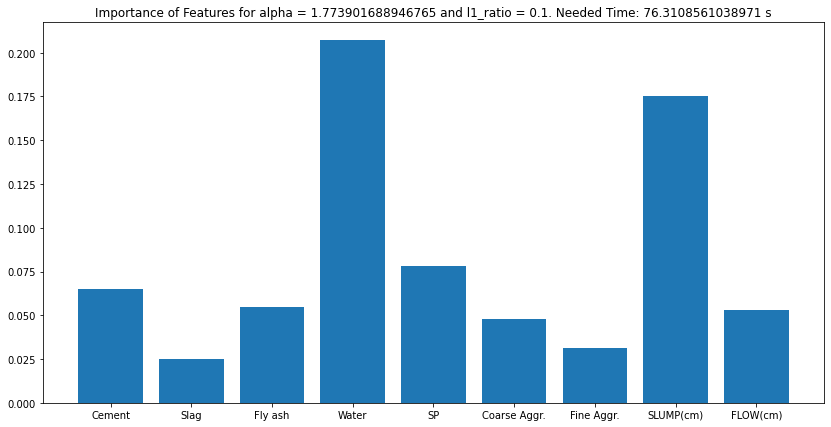

In [ ]:
model = ElasticNet(alpha=X_[0][0], l1_ratio=X_[0][1]).fit(X_train, y_train)
importance = np.abs(model.coef_)
plt.figure(figsize=(14, 7))
plt.bar(data_cols, importance)
plt.title('Importance of Features for alpha = {} and l1_ratio = {}. Needed Time: {} s'.format(X_[0][0], X_[0][1], end_time))
plt.show()

In [ ]:
impIdx = np.nonzero(importance > 0.01)[0]

X_train_sel = X_train[:, impIdx]
X_test_sel = X_test[:, impIdx]

gpr = train_gp(X_train_sel, y_train)
r2_test = gpr.score(X_test_sel, y_test)
print('We have {} Features.'.format(len(impIdx)))
print('R2 for Test data: {}'.format(r2_test))

We have 9 Features.
R2 for Test data: 0.9753063612921089


# Extending Auto-Sklearn with Regression Components

Lasso

In [ ]:
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, \
    UniformIntegerHyperparameter, CategoricalHyperparameter
from ConfigSpace.conditions import EqualsCondition

import sklearn.metrics
import autosklearn.regression
import autosklearn.pipeline.components.regression
from autosklearn.pipeline.components.base import AutoSklearnRegressionAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, \
    SIGNED_DATA, UNSIGNED_DATA, PREDICTIONS

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [ ]:
class Lasso(AutoSklearnRegressionAlgorithm):

    def __init__(self, alpha, random_state=None):
        self.alpha = alpha
        self.random_state = random_state
        self.estimator = None

    def fit(self, X, y):
        self.alpha = float(self.alpha)

        from sklearn.linear_model import Lasso
        self.estimator = Lasso(
            alpha=self.alpha, fit_intercept=False
        )
        self.estimator.fit(X, y)
        return self

    def predict(self, X):
        if self.estimator is None:
            raise NotImplementedError
        return self.estimator.predict(X)

    @staticmethod
    def get_properties(dataset_properties=None):
        return {
            'shortname': 'L1',
            'name': 'Lasso',
            'handles_regression': True,
            'handles_classification': False,
            'handles_multiclass': False,
            'handles_multilabel': False,
            'handles_multioutput': False,
            'is_deterministic': True,
            'input': (SPARSE, DENSE, UNSIGNED_DATA, SIGNED_DATA),
            'output': (PREDICTIONS,)
        }

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        cs = ConfigurationSpace()
        alpha = UniformFloatHyperparameter(
            name='alpha', lower=10 ** -3, upper=10 ** 2, log=True, default_value=1.0
        )
        cs.add_hyperparameters([alpha])
        return cs


# Add KRR component to auto-sklearn.
autosklearn.pipeline.components.regression.add_regressor(Lasso)
cs = Lasso.get_hyperparameter_search_space()
print(cs)


Configuration space object:
  Hyperparameters:
    alpha, Type: UniformFloat, Range: [0.001, 100.0], Default: 1.0, on log-scale



In [ ]:
reg = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=20,
    include={
        'regressor': ['Lasso']
    },
    ensemble_size=1
)
reg.fit(X_train, y_train)

[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 197 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 235 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 270 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 163 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 67 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 34 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 86 not found
[WARNING] [2022-06-24 15:01:26,334:Client-AutoMLSMBO(1)::84a682d8-f3ce-11ec-8244-0242ac1c0002] Configuration 240 not found
[WARNING] [2022-06-

AutoSklearnRegressor(ensemble_size=1, include={'regressor': ['Lasso']},
                     per_run_time_limit=20, time_left_for_this_task=60)

In [ ]:
y_pred = reg.predict(X_test)
print("r2 score: ", sklearn.metrics.r2_score(y_pred, y_test))
print(reg.show_models())

r2 score:  0.9629292656799505
{14: {'model_id': 14, 'rank': 1, 'cost': 0.10098702710844842, 'ensemble_weight': 1.0, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fbcb6e8e5d0>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fbcb73aab90>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7fbcb7122550>, 'sklearn_regressor': Lasso(alpha=0.00014285611982465114, fit_intercept=False)}}


In [ ]:
model_dict = reg.show_models()
key = list(model_dict.keys())[0]
alpha = model_dict[key]['sklearn_regressor'].alpha
print(alpha)

0.003695272009069391


<BarContainer object of 9 artists>

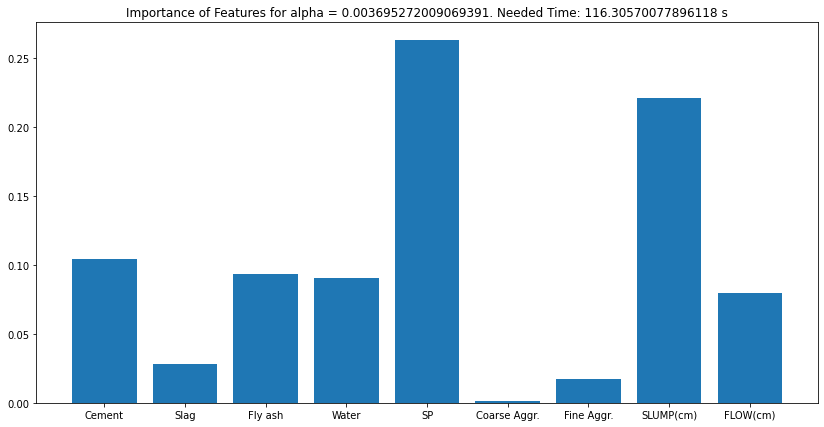

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=alpha, fit_intercept=False).fit(X_train, y_train)
importance = np.abs(lasso.coef_)
plt.figure(figsize=(14, 7))
plt.title('Importance of Features for alpha = {}. Needed Time: {} s'.format(alpha, needed_time))
plt.bar(data_cols, importance)